In [ ]:
import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import random
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sklearn


In [ ]:
df = pd.read_csv("model_data.csv")
# Drop the "tema" column
df = df.drop("Unnamed: 0.1", axis=1)
df = df.drop("Unnamed: 0", axis=1)
df.set_index('Date', inplace=True)

In [ ]:
# Define the features for which you want to add differential privacy
features = ['ema', 'rsi', 'macd', 'compound', 'subjectivity', 'polarity']

# Calculate the variances for each feature
variances = np.var(df[features], axis=0)

# Set the privacy budget and noise level
epsilon = 1.0
noise = 0.1

# Calculate the standard deviations for each feature
sigmas = np.sqrt(noise * variances)

# Generate the noisy data
df_noise = df.copy()

for feature in features:
    mu = 0
    sigma = sigmas[feature]
    df_noise[feature] += np.random.normal(mu, sigma, size=len(df))

df = df_noise

In [ ]:
def sliding_windows(data, seq_length):
    #data_array = data.values  # Convert DataFrame to numpy array
    x = []
    y = []

    for i in range(len(data)-seq_length+1):
        _x = data[i:(i+seq_length), :-1]  # Exclude the last column (label) from _x
        _y = data[i+seq_length-1, -1]  # Label is taken from the last column of the next row
        _x[-1, -1] = _y  # Replace the last element of the sequence with the label
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)


In [ ]:
inv_data =pd.read_csv("model_data.csv")
# Drop the "tema" column
inv_data = inv_data.drop("Unnamed: 0.1", axis=1)
inv_data = inv_data.drop("Unnamed: 0", axis=1)
inv_data.set_index('Date', inplace=True)
inv_data_y = inv_data['target']
inv_data_y = inv_data_y.values

# Manually rescale the predictions and targets based on the original data range
data_min = np.min(inv_data_y)  # Minimum value of the original data
data_max = np.max(inv_data_y)  # Maximum value of the original data




In [ ]:
#sc = MinMaxScaler()
#training_data = sc.fit_transform(train)
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
data = sc.fit_transform(df)

seq_length = 10
x, y = sliding_windows(data, seq_length)

train_size = int(len(y) * 0.80)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[0:train_size])))
y_train = Variable(torch.Tensor(np.array(y[0:train_size])))

X_test = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_test = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
# Create training and testing datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size= 32
# Create data loaders for batching the datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,drop_out):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(drop_out)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout(out)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = self.dropout(out[:, -1, :])  # Take the last time step output
        out = self.linear(out)
        return out

In [ ]:
from torch.types import Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


input_dim = 18  # Example input dimension
hidden_dim = 50  # Example hidden dimension
output_dim = 1  # Example output dimension
drop_out = 0.2  # Example dropout rate

model = LSTMModel(input_dim, hidden_dim, output_dim,drop_out).to(device)

In [ ]:

# setting up hyperparameters
learning_rate = 0.001


# Initialize the model and the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Define the loss function
criterion = nn.MSELoss()

In [ ]:
num_epochs=500
# Train the LSTM model
for epoch in range(num_epochs):
    for i, (sequences, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(sequences.float()) # cast input tensor to Float
        loss = criterion(outputs, labels.float().unsqueeze(1)) # cast label tensor to Float
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/500], Loss: 0.0210
Epoch [20/500], Loss: 0.0044
Epoch [30/500], Loss: 0.0063
Epoch [40/500], Loss: 0.0059
Epoch [50/500], Loss: 0.0033
Epoch [60/500], Loss: 0.0040
Epoch [70/500], Loss: 0.0080
Epoch [80/500], Loss: 0.0053
Epoch [90/500], Loss: 0.0016
Epoch [100/500], Loss: 0.0060
Epoch [110/500], Loss: 0.0045
Epoch [120/500], Loss: 0.0083
Epoch [130/500], Loss: 0.0021
Epoch [140/500], Loss: 0.0032
Epoch [150/500], Loss: 0.0053
Epoch [160/500], Loss: 0.0012
Epoch [170/500], Loss: 0.0069
Epoch [180/500], Loss: 0.0034
Epoch [190/500], Loss: 0.0021
Epoch [200/500], Loss: 0.0022
Epoch [210/500], Loss: 0.0038
Epoch [220/500], Loss: 0.0038
Epoch [230/500], Loss: 0.0030
Epoch [240/500], Loss: 0.0049
Epoch [250/500], Loss: 0.0027
Epoch [260/500], Loss: 0.0009
Epoch [270/500], Loss: 0.0028
Epoch [280/500], Loss: 0.0008
Epoch [290/500], Loss: 0.0049
Epoch [300/500], Loss: 0.0013
Epoch [310/500], Loss: 0.0039
Epoch [320/500], Loss: 0.0016
Epoch [330/500], Loss: 0.0009
Epoch [340/500], Lo

In [ ]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
predictions = []
targets = []

with torch.no_grad():
    for sequences, labels in test_loader:
        outputs = model(sequences.float())  # cast input tensor to Float
        loss = criterion(outputs, labels.float().unsqueeze(1))  # cast label tensor to Float
        test_loss += loss.item() * sequences.size(0)

        # Convert predictions and labels back to their original scale
        predictions.extend((outputs.cpu().numpy() * (data_max - data_min)) + data_min)
        targets.extend((labels.cpu().numpy() * (data_max - data_min)) + data_min)


In [ ]:
import numpy as np

# Convert predictions and targets to numpy arrays
predictions = np.array(predictions)
targets = np.array(targets)

# Calculate MSE
mse = np.mean((predictions - targets) ** 2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate accuracy (assuming a threshold for classification)
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)
binary_targets = (targets >= threshold).astype(int)
accuracy = np.mean(binary_predictions == binary_targets)

# Calculate mean error percentage
mean_error_percentage = np.mean(np.abs((predictions - targets) / targets)) * 100

print("MSE:", mse)
print("RMSE:", rmse)
print("Accuracy:", accuracy)
print("Mean Error Percentage:", mean_error_percentage)


MSE: 108.83064
RMSE: 10.432193
Accuracy: 1.0
Mean Error Percentage: 5.275355279445648


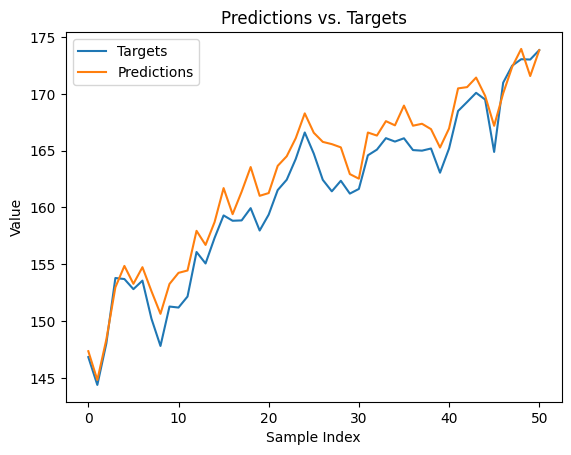

In [ ]:
import matplotlib.pyplot as plt

# Plot the predicted and target values
plt.plot(targets, label='Targets')
plt.plot(predictions, label='Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Predictions vs. Targets')
plt.legend()
plt.show()